# seismic amplitude extraction

Inspired by a strong hate towards [ _insert your most hated interpretation platform here_ ], here's how to do basic amplitude extraction in Python.

Similarly to what I did for my [Seismic Petrophysics notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb), I will use data available from the Quantitative Seismic Interpretation (QSI) book [website](https://srb.stanford.edu/quantitative-seismic-interpretation).

**Revision history**:

* 2020-06: replaced segyio with segysak
* 2019-01: first version

## data loading & preparation

First load the required libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from segysak.segy import get_segy_texthead, segy_header_scan, segy_loader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

Then use [segysak](https://github.com/trhallam/segysak) to scan the SEG-Y headers and then load the cube:

In [2]:
pwd

'C:\\Users\\ag19324\\GOOGLEDRIVE\\GITHUB\\geophysical_notes'

In [4]:
filename='3d_nearstack.sgy'
scan = segy_header_scan(filename, max_traces_scan=0)
with pd.option_context('display.max_rows', 89):
    display(scan[scan['mean'] > 0])
#     display(scan)

  0%|          | 0.00/25.4k [00:00<?, ? traces/s]

byte_loc    count          mean           std  \
TRACE_SEQUENCE_LINE             1  25351.0  7.779100e+04  15044.327101   
TRACE_SEQUENCE_FILE             5  25351.0  7.779100e+04  15044.327101   
FieldRecord                     9  25351.0  1.921123e+02    394.060648   
TraceNumber                    13  25351.0  3.698050e+02    230.804810   
EnergySourcePoint              17  25351.0  1.921123e+02    394.060648   
CDP                            21  25351.0  1.750000e+03    144.916626   
CDP_TRACE                      25  25351.0  1.000000e+00      0.000000   
TraceIdentificationCode        29  25351.0  1.000000e+00      0.000000   
NStackedTraces                 33  25351.0  3.200000e+01      0.000000   
offset                         37  25351.0  5.880000e+02      0.000000   
ReceiverGroupElevation         41  25351.0  1.400000e+06  58310.669026   
SourceWaterDepth               61  25351.0  6.000000e+03      0.000000   
GroupWaterDepth                65  25351.0  8.000000e+03      0.000000   
SourceGroupScalar              71  25351.0  1.000000e+00      0.000000   
SourceX                        73  25351.0  4.211156e+05   1216.404587   
SourceY                        77  25351.0  6.509573e+06   1531.398814   
GroupX                         81  25351.0  4.207963e+05   1210.920244   
GroupY                         85  25351.0  6.509085e+06   1530.294762   
CoordinateUnits                89  25351.0  3.000000e+00      0.000000   
SourceStaticCorrection         99  25351.0  3.957725e+03    386.556264   
TotalStaticApplied            103  25351.0  1.000000e+01      0.000000   
MuteTimeStart                 111  25351.0  8.800000e+01      0.000000   
MuteTimeEND                   113  25351.0  1.080000e+02      0.000000   
TRACE_SAMPLE_COUNT            115  25351.0  2.500000e+02      0.000000   
TRACE_SAMPLE_INTERVAL         117  25351.0  4.000000e+03      0.000000   
LowCutFrequency               149  25351.0  3.000000e+00      0.000000   
HighCutFrequency              151  25351.0  1.800000e+02      0.000000   
LowCutSlope                   153  25351.0  1.800000e+01      0.000000   
HighCutSlope                  155  25351.0  7.000000e+01      0.000000   

                               min        25%        50%        75%        max  
TRACE_SEQUENCE_LINE        51866.0    64828.5    77791.0    90753.5   103716.0  
TRACE_SEQUENCE_FILE        51866.0    64828.5    77791.0    90753.5   103716.0  
FieldRecord                    0.0        0.0        0.0        0.0     1158.0  
TraceNumber                   30.0      207.0      339.0      515.0      754.0  
EnergySourcePoint              0.0        0.0        0.0        0.0     1158.0  
CDP                         1500.0     1624.0     1750.0     1876.0     2000.0  
CDP_TRACE                      1.0        1.0        1.0        1.0        1.0  
TraceIdentificationCode        1.0        1.0        1.0        1.0        1.0  
NStackedTraces                32.0       32.0       32.0       32.0       32.0  
offset                       588.0      588.0      588.0      588.0      588.0  
ReceiverGroupElevation   1300000.0  1350000.0  1400000.0  1450000.0  1500000.0  
SourceWaterDepth            6000.0     6000.0     6000.0     6000.0     6000.0  
GroupWaterDepth             8000.0     8000.0     8000.0     8000.0     8000.0  
SourceGroupScalar              1.0        1.0        1.0        1.0        1.0  
SourceX                   418258.0   420196.0   421116.0   422037.0   424063.0  
SourceY                  6506317.0  6508299.0  6509573.0  6510848.0  6512852.0  
GroupX                    417935.0   419877.5   420796.0   421719.0   423674.0  
GroupY                   6505784.0  6507808.5  6509084.0  6510360.0  6512346.0  
CoordinateUnits                3.0        3.0        3.0        3.0        3.0  
SourceStaticCorrection      3285.0     3622.0     3957.0     4293.0     4636.0  
TotalStaticApplied            10.0       10.0       10.0       10.0       10.0  
MuteTimeStart         

In [5]:
bytelocs = dict(iline=41, xline=21, cdpx=73, cdpy=77)
near = segy_loader(filename, **bytelocs)
near = near.assign_coords(iline=near.iline/1000, twt=near.twt+1500)

  0%|          | 0.00/25.4k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is ReceiverGroupElevation


Converting SEGY:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

QSI reports the following information, let's check them out:

* inline: 1300-1500, every 2
* xline: 1500-2000, every 2
* time: 1500-2500 ms
* total 25351 traces for each subcube.

In [6]:
print('Inlines: {:.0f}, min={:.0f}, max={:.0f}'.format(near.iline.size, near.iline.values.min(), near.iline.values.max()))
print('Crosslines: {:.0f}, min={:.0f}, max={:.0f}'.format(near.xline.size, near.xline.values.min(), near.xline.values.max()))
print('TWT: {:.0f}, min={:.0f}, max={:.0f}'.format(near.twt.size, near.twt.values.min(), near.twt.values.max()))
print('Total number of traces: {}'.format(near.iline.size*near.xline.size))

Inlines: 101, min=1300, max=1500
Crosslines: 251, min=1500, max=2000
TWT: 250, min=1500, max=2496
Total number of traces: 25351


## Interactive seismic visualizer

Modified after Rob Leckenby's Tutorial ["Getting Started with Python"](https://github.com/Zabamund/transform2020-getting-started-python/blob/master/Getting_started_with_Python_live.ipynb) (Transform 2020).

In [7]:
def seismic_plotter(section, seismic, colormap, il, xl, ts):
    """Plot a given seismic ILine, XLine or Timeslice with a choice of colormaps"""
    
    # display options for different sections
    sections = {
        'inline': {
            'amp': seismic.data.sel(iline=il),
            'opt': dict(x='xline', y='twt', add_colorbar=True, interpolation='spline16',
                        robust=True, yincrease=False, cmap=colormap),
            'line': il,
            'axhline_y': ts, 'axhline_c': 'b', 
            'axvline_x': xl, 'axvline_c': 'g',
            'axspine_c': 'r',
            'aspect': 'auto' },
        'xline': {
            'amp': seismic.data.sel(xline=xl),
            'opt': dict(x='iline', y='twt', add_colorbar=True, interpolation='spline16',
                        robust=True, yincrease=False, cmap=colormap),
            'line': xl,
            'axhline_y': ts, 'axhline_c': 'b', 
            'axvline_x': il, 'axvline_c': 'r',
            'axspine_c': 'g',
            'aspect': 'auto'},
        'timeslice': {
            'amp': seismic.data.sel(twt=ts),
            'opt': dict(x='iline', y='xline', add_colorbar=True, interpolation='spline16',
                        robust=True, cmap=colormap),
            'line': ts,
            'axhline_y': xl, 'axhline_c': 'g', 
            'axvline_x': il, 'axvline_c': 'r',
            'axspine_c': 'b',
            'aspect': 'equal' },        
    }
    
    # plot figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # apply options
    ss = sections[section]
    ss['amp'].plot.imshow(ax=ax, **ss['opt'])
     
    # add projected lines
    ax.axhline(y=ss['axhline_y'], linewidth=1.5, color=ss['axhline_c'])
    ax.axvline(x=ss['axvline_x'], linewidth=1.5, color=ss['axvline_c'])
    ax.set_aspect(ss['aspect'])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)     
        ax.spines[axis].set_color(ss['axspine_c'])
    return

In [8]:
ilmin, ilmax = near.iline.values.min(), near.iline.values.max()
ilmid = int((ilmax-ilmin)/2+ilmin)
ilstep = int(np.unique(np.diff(near.iline.values)))

xlmin, xlmax = near.xline.values.min(), near.xline.values.max()
xlmid = int((xlmax-xlmin)/2+xlmin)
xlstep = int(np.unique(np.diff(near.xline.values)))

tsmin, tsmax = near.twt.values.min(), near.twt.values.max()
tsmid = 2000
tsstep = int(np.unique(np.diff(near.twt.values)))

In [19]:
widg_slicer = widgets.ToggleButtons(options=['inline', 'xline', 'timeslice'],
                                value='inline', description='slicer', disabled=False)

widg_il = widgets.IntSlider(value=ilmid, min=ilmin, max=ilmax, step=ilstep, continuous_update=False,
                            description='inline')

widg_xl = widgets.IntSlider(value=xlmid, min=xlmin, max=xlmax, step=xlstep, continuous_update=False,
                            description='xline')

widg_ts = widgets.IntSlider(value=tsmid, min=tsmin, max=tsmax,step=tsstep, continuous_update=False,
                       description='twt')

widg_cmap = widgets.Dropdown(options=['Greys', 'Greys_r', 'seismic', 'seismic_r'],
                             value='Greys', description='Colormap:', disabled=False)

box_sel = widgets.VBox([widg_slicer, widg_il, widg_xl, widg_ts])
ui = widgets.HBox([box_sel, widg_cmap])

tool = widgets.interactive_output(seismic_plotter, {
    'section':widg_slicer, 'seismic':fixed(near),
    'colormap': widg_cmap,
    'il': widg_il, 'xl': widg_xl, 'ts': widg_ts})

In [20]:
display(ui, tool)

Output()

## load and display interpreted horizon

In [31]:
#--- load horizon as xarray
# hrz = pd.read_csv('Top_Heimdal_subset.txt', names=['il', 'xl', 'twt'], sep='\s+').to_xarray()
# hrz = hrz.set_coords(('iline', 'xline', 'twt'))
# hrz = hrz.set_index(index=('iline', 'xline', 'twt'))

#--- load horizon as pandas DataFrame
hrz = pd.read_csv('Top_Heimdal_subset.txt', names=['il', 'xl', 'twt'], sep='\s+')

In [33]:
x, t = hrz[hrz.il==1376]['xl'], hrz[hrz.il==1376]['twt']

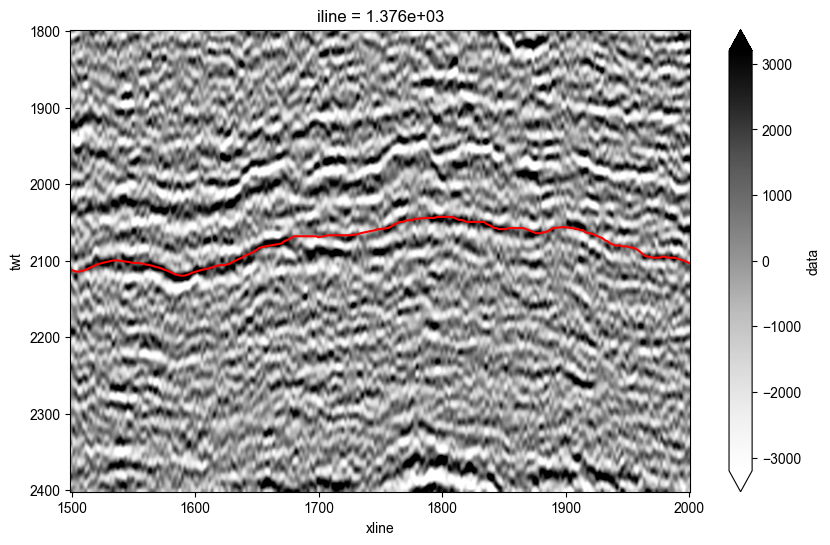

In [34]:
val = 1376

iline = near.data.sel(iline=val, twt=slice(1800, 2400))
opt = dict(y='twt', add_colorbar=True,
        interpolation='spline16', robust=True,
        yincrease=False, cmap='Greys')

f, ax = plt.subplots(figsize=(10,6))
iline.plot.imshow(ax=ax, x='xline', **opt)
x, t = hrz[hrz.il==val]['xl'], hrz[hrz.il==val]['twt']
# x, t = hrz.sel(iline=val).xline, hrz.sel(iline=val).twt
ax.plot(x, t, color='r')


### fancy interlude: interactive viewer for 3D data

A fancier display showing one inline, one crossline and a timeslice of your choice (uses the interactive widgets of IPython/Jupyter notebooks so it only works when the notebook is run locally):

In [35]:
seis = near.data

3840.0

In [36]:
@interact(ii=(1300,1500,24),cc=(1500,2000,48),zz=(1800,2496,48))
def seisview3d(ii=1372, cc=1788, zz=2136):
    clip=abs(np.percentile(seis, 0.80))   

    ii_idx=inl.tolist().index(ii)
    cc_idx=crl.tolist().index(cc)
    zz_idx=twt.tolist().index(zz)
    
    f, ax = plt.subplots(1,3, figsize=(14,6))
    ax[0].imshow(seis[:,ii_idx,:],extent=[crl.min(),crl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[0].plot(hrz[hrz['il']==ii]['xl'],hrz[hrz['il']==ii]['z'],color='r') 
    ax[0].axhline(zz,color='y',lw=2)
    ax[0].axvline(cc,color='y',lw=2)   
    ax[0].set_ylim(twt.max(),1800)
    ax[0].set_title('IL {0}'.format(ii))
    ax[0].set_xlabel('XL'), ax[0].set_ylabel('TWT [ms]')

    ax[1].imshow(seis[:,:,cc_idx],extent=[inl.min(),inl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[1].plot(hrz[hrz['xl']==cc]['il'],hrz[hrz['xl']==cc]['z'],color='r')
    ax[1].axhline(zz,color='y',lw=2)
    ax[1].axvline(ii,color='y',lw=2)
    ax[1].set_ylim(twt.max(),1800)
    ax[1].set_title('XL {0}'.format(cc))
    ax[1].set_xlabel('IL'), ax[1].set_ylabel('TWT [ms]')

    ax[2].imshow(seis[zz_idx,:,:],extent=[inl.min(),inl.max(),crl.min(),crl.max()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[2].axhline(cc,color='y',lw=2)
    ax[2].axvline(ii,color='y',lw=2)
    ax[2].set_title('TWT {0}'.format(zz))
    ax[2].set_xlabel('IL'), ax[2].set_ylabel('XL')
    f.subplots_adjust(wspace=.4)

interactive(children=(IntSlider(value=1372, description='ii', max=1500, min=1300, step=24), IntSlider(value=17…

In [39]:
from ipywidgets import interact
    
@interact(ii=(1300,1500,24),cc=(1500,2000,48),zz=(1800,2496,48))
def seisview3d(ii=1372,cc=1788,zz=2136):
    clip=abs(np.percentile(seis, 0.80))   

    ii_idx=inl.tolist().index(ii)
    cc_idx=crl.tolist().index(cc)
    zz_idx=twt.tolist().index(zz)
    
    f, ax = plt.subplots(1,3, figsize=(14,6))

    ax[0].imshow(seis[:,ii_idx,:],extent=[crl.min(),crl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[0].plot(hrz[hrz['il']==ii]['xl'],hrz[hrz['il']==ii]['z'],color='r') 
    ax[0].axhline(zz,color='y',lw=2)
    ax[0].axvline(cc,color='y',lw=2)   
    ax[0].set_ylim(twt.max(),1800)
    ax[0].set_title('IL {0}'.format(ii))
    ax[0].set_xlabel('XL'), ax[0].set_ylabel('TWT [ms]')

    ax[1].imshow(seis[:,:,cc_idx],extent=[inl.min(),inl.max(),twt.max(),twt.min()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[1].plot(hrz[hrz['xl']==cc]['il'],hrz[hrz['xl']==cc]['z'],color='r')
    ax[1].axhline(zz,color='y',lw=2)
    ax[1].axvline(ii,color='y',lw=2)
    ax[1].set_ylim(twt.max(),1800)
    ax[1].set_title('XL {0}'.format(cc))
    ax[1].set_xlabel('IL'), ax[1].set_ylabel('TWT [ms]')

    ax[2].imshow(seis[zz_idx,:,:],extent=[inl.min(),inl.max(),crl.min(),crl.max()],cmap='Greys',vmax=clip,vmin=-clip,aspect='auto')
    ax[2].axhline(cc,color='y',lw=2)
    ax[2].axvline(ii,color='y',lw=2)
    ax[2].set_title('TWT {0}'.format(zz))
    ax[2].set_xlabel('IL'), ax[2].set_ylabel('XL')
    f.subplots_adjust(wspace=.4)

interactive(children=(IntSlider(value=1372, description='ii', max=1500, min=1300, step=24), IntSlider(value=17…

## extracting amplitudes, the basics

Amplitudes along an horizon can be extracted in 3 ways:

* get the amplitude value from sample closer to actual pick (fastest)
* interpolate with `scipy.interpolate.interp1d` (slow)
* interpolate with `scipy.interpolate.splrep` / `splev` (unexpectedly fast)

As an exercise I will compare these three methods and show the elapsed time to do the extraction for a single inline:

In [11]:
import time
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep

hrz_sub=hrz[hrz['il']==1376]
twt_finer=np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale

amp0=np.zeros((hrz_sub.size,2))
start = time.time()
for i in range(hrz_sub.size):
    ii_idx=inl.tolist().index(hrz_sub['il'][i])
    cc_idx=crl.tolist().index(hrz_sub['xl'][i])  
    zz_idx = np.abs(twt-hrz_sub['z'][i]).argmin()
    amp0[i,0] = hrz_sub['xl'][i]
    amp0[i,1] = seis[zz_idx, ii_idx, cc_idx]
end = time.time()
elapsed_raw = end - start

amp1=np.zeros((hrz_sub.size,2))
start = time.time()
for i in range(hrz_sub.size):
    ii_idx=inl.tolist().index(hrz_sub['il'][i])
    cc_idx=crl.tolist().index(hrz_sub['xl'][i])  
    trace = seis[:, ii_idx, cc_idx].flatten()
    ff = interp1d(twt, trace, kind='cubic')
    amp1[i,0] = hrz_sub['xl'][i]
    amp1[i,1] = ff(hrz_sub['z'][i])
end = time.time()
elapsed_interp1d = end - start

amp2=np.zeros((hrz_sub.size,2))
start = time.time()
for i in range(hrz_sub.size):
    ii_idx=inl.tolist().index(hrz_sub['il'][i])
    cc_idx=crl.tolist().index(hrz_sub['xl'][i])  
    trace = seis[:, ii_idx, cc_idx].flatten()
    ff = splrep(twt, trace)
    amp2[i,0] = hrz_sub['xl'][i]
    amp2[i,1] = splev(hrz_sub['z'][i], ff)
end = time.time()
elapsed_splev = end - start

print('Time to extract amplitudes at closest sample: {:.2f} seconds.'.format(elapsed_raw))
print('Time to extract amplitudes by interpolation with interp1d: {:.2f} seconds.'.format(elapsed_interp1d))
print('Time to extract amplitudes by interpolation with splrep/splev: {:.2f} seconds.'.format(elapsed_splev))

diff = amp1[:,1] - amp2[:,1]
print('Average difference between interp1d and splrep/splev: {0}'.format(np.mean(diff)))

Time to extract amplitudes at closest sample: 0.03 seconds.
Time to extract amplitudes by interpolation with interp1d: 12.71 seconds.
Time to extract amplitudes by interpolation with splrep/splev: 0.07 seconds.
Average difference between interp1d and splrep/splev: -4.149597885314513e-13


The last output above also confirms that `interp1d` and `splrep / splev` deliver the same results; as it is much slower, I will therefore drop the use of `interp1d` from now on.

Now, a graphical comparison between raw vs interpolated amplitudes:

(1600, 1900)

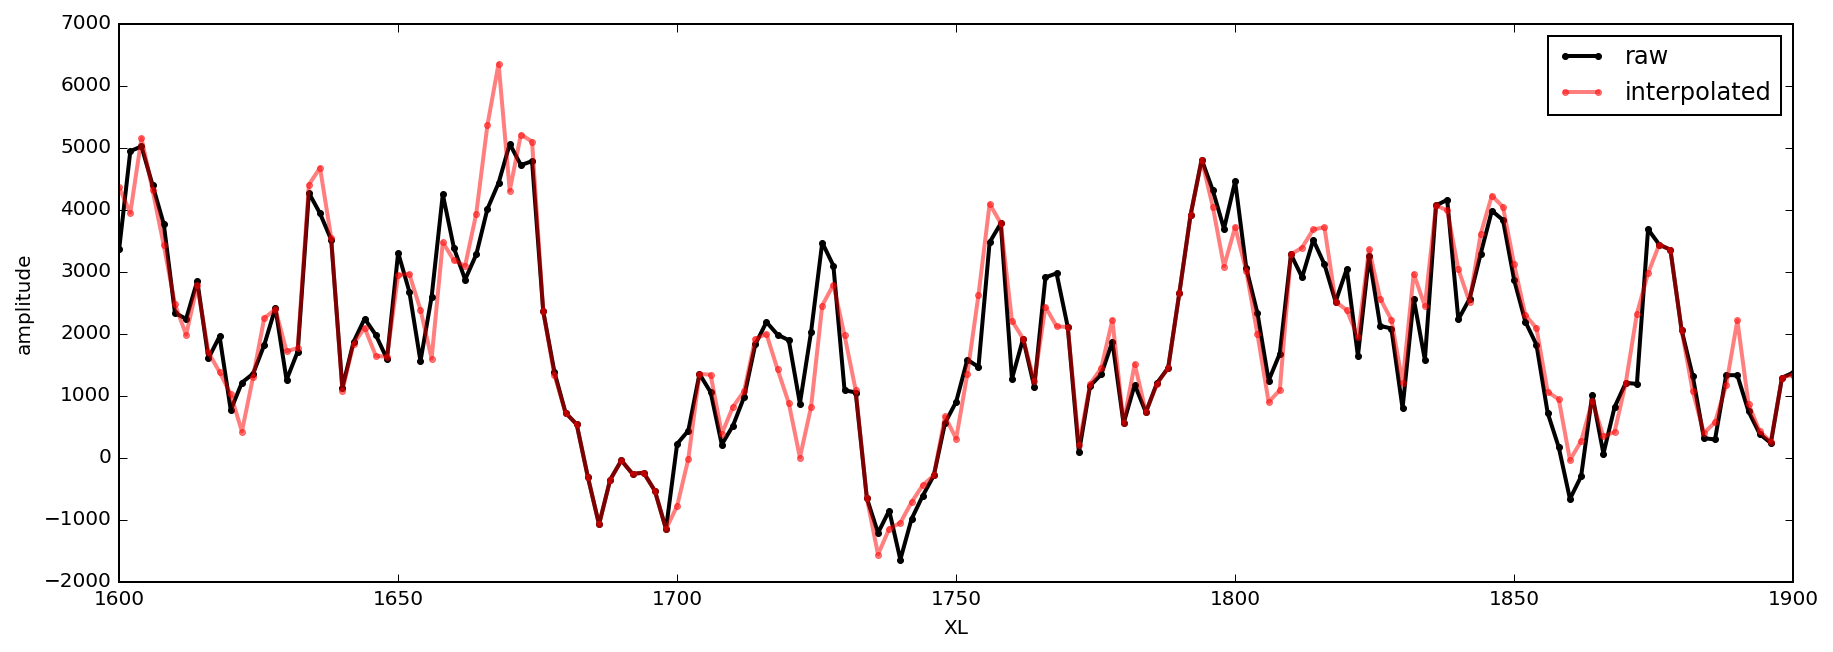

In [12]:
plt.figure(figsize=(15,5))
plt.plot(amp0[:,0], amp0[:,1], '.-k', lw=2, label='raw')
plt.plot(amp2[:,0], amp2[:,1], '.-r', lw=2, alpha=0.5, label='interpolated')
plt.legend()
plt.xlabel('XL')
plt.ylabel('amplitude')
plt.xlim(1600,1900)

## amplitude extraction on 3D data

I will now extend the method above to cover the entire 3D dataset.

First I create an array to contain all the background information (geometry and interpretion) and the results of the extraction; this array `hrz_extr` will have 6 columns and as many rows as the original interpretation:
 
* column 0 = inline
* column 1 = crossline
* column 2 = picked two-way-time picks
* column 3 = amplitude of closest sample
* column 4 = amplitude interpolated at actual pick time with `splev / sprep`
* column 5 = windowed RMS amplitude

In [13]:
hrz_extr = np.zeros((hrz.size,6))
twt_finer = np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale
window = 8 # 8 samples = 32 ms

start = time.time()
for i in range(hrz.size):
    ii_idx=inl.tolist().index(hrz['il'][i])
    cc_idx=crl.tolist().index(hrz['xl'][i])  
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()
    amp_raw = seis[zz_idx, ii_idx, cc_idx].flatten()
    amp_rms = np.sqrt(np.mean((np.square(seis[zz_idx-int(window/2):zz_idx+int(window/2), ii_idx, cc_idx]))))
    
    trace = seis[:, ii_idx, cc_idx].flatten()
    ff = splrep(twt, trace)
    amp_splev = splev(hrz['z'][i], ff)

    hrz_extr[i,0] = hrz['il'][i]
    hrz_extr[i,1] = hrz['xl'][i]
    hrz_extr[i,2] = hrz['z'][i]
    hrz_extr[i,3] = amp_raw
    hrz_extr[i,4] = amp_splev
    hrz_extr[i,5] = amp_rms
end = time.time()
elapsed = end - start

print('Time to extract amplitudes on 3D cube: {:.2f} seconds.'.format(elapsed))

Time to extract amplitudes on 3D cube: 3.83 seconds.


Let's grid the data and display it as 2D maps:

In [14]:
from scipy.interpolate import griddata
from scipy import ndimage

xi = np.linspace(inl.min(), inl.max(),250)
yi = np.linspace(crl.min(), crl.max(),250)
X, Y = np.meshgrid(xi, yi)
Z=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,2],(X,Y),method='cubic')
Araw=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,3],(X,Y),method='cubic')
Aspl=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,4],(X,Y),method='cubic')
Arms=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,5],(X,Y),method='cubic')

# smooth the time interpretation for a nicer contouring
Zf=ndimage.gaussian_filter(Z,sigma=3,order=0)

This first plot is useful to compare the results of using "raw" vs interpolated amplitude:

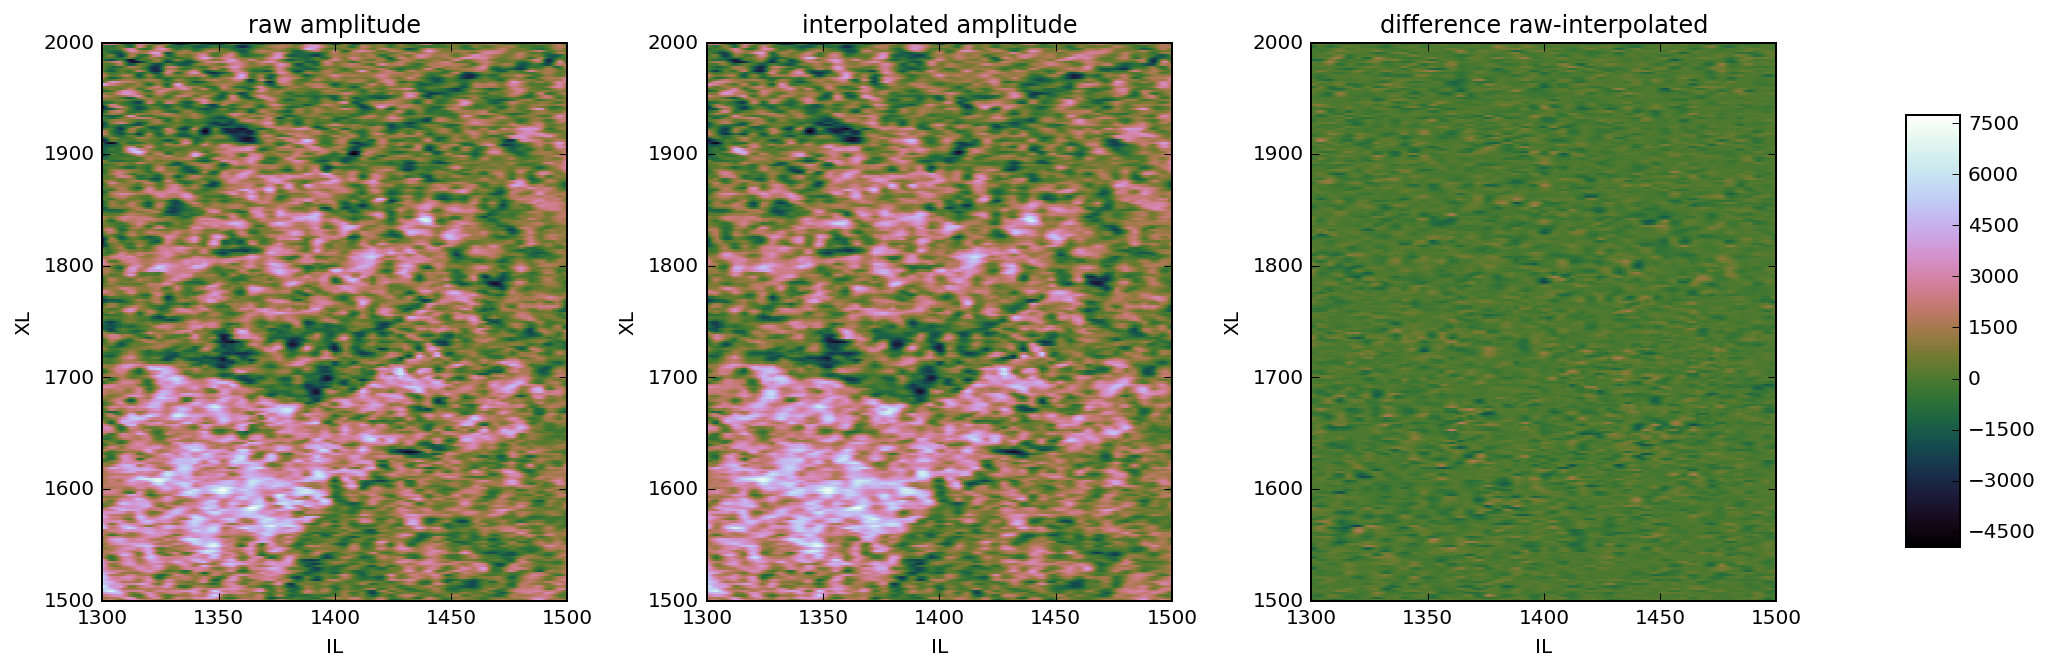

In [15]:
clip_max=np.max(hrz_extr[:,3:5])
clip_min=np.min(hrz_extr[:,3:5])

f, ax = plt.subplots(1,3,figsize=(15,5))
map0 = ax[0].pcolormesh(X, Y, Araw, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
map1 = ax[1].pcolormesh(X, Y, Aspl, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
map2 = ax[2].pcolormesh(X, Y, Araw-Aspl, vmin=clip_min, vmax=clip_max, cmap='cubehelix')
ax[0].set_title('raw amplitude')
ax[1].set_title('interpolated amplitude')
ax[2].set_title('difference raw-interpolated')
for aa in ax.flatten():
    aa.set_xlabel('IL'), aa.set_ylabel('XL')
f.subplots_adjust(wspace=.3)
cax = f.add_axes([0.96, 0.2, 0.025, 0.6])
f.colorbar(map0, cax=cax, orientation='vertical')

The following plot shows more clearly the differences between the two types of extraction along a few inlines:

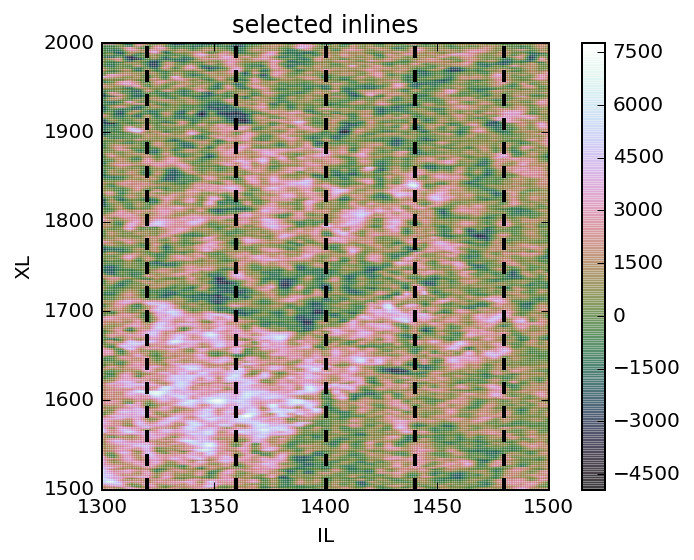

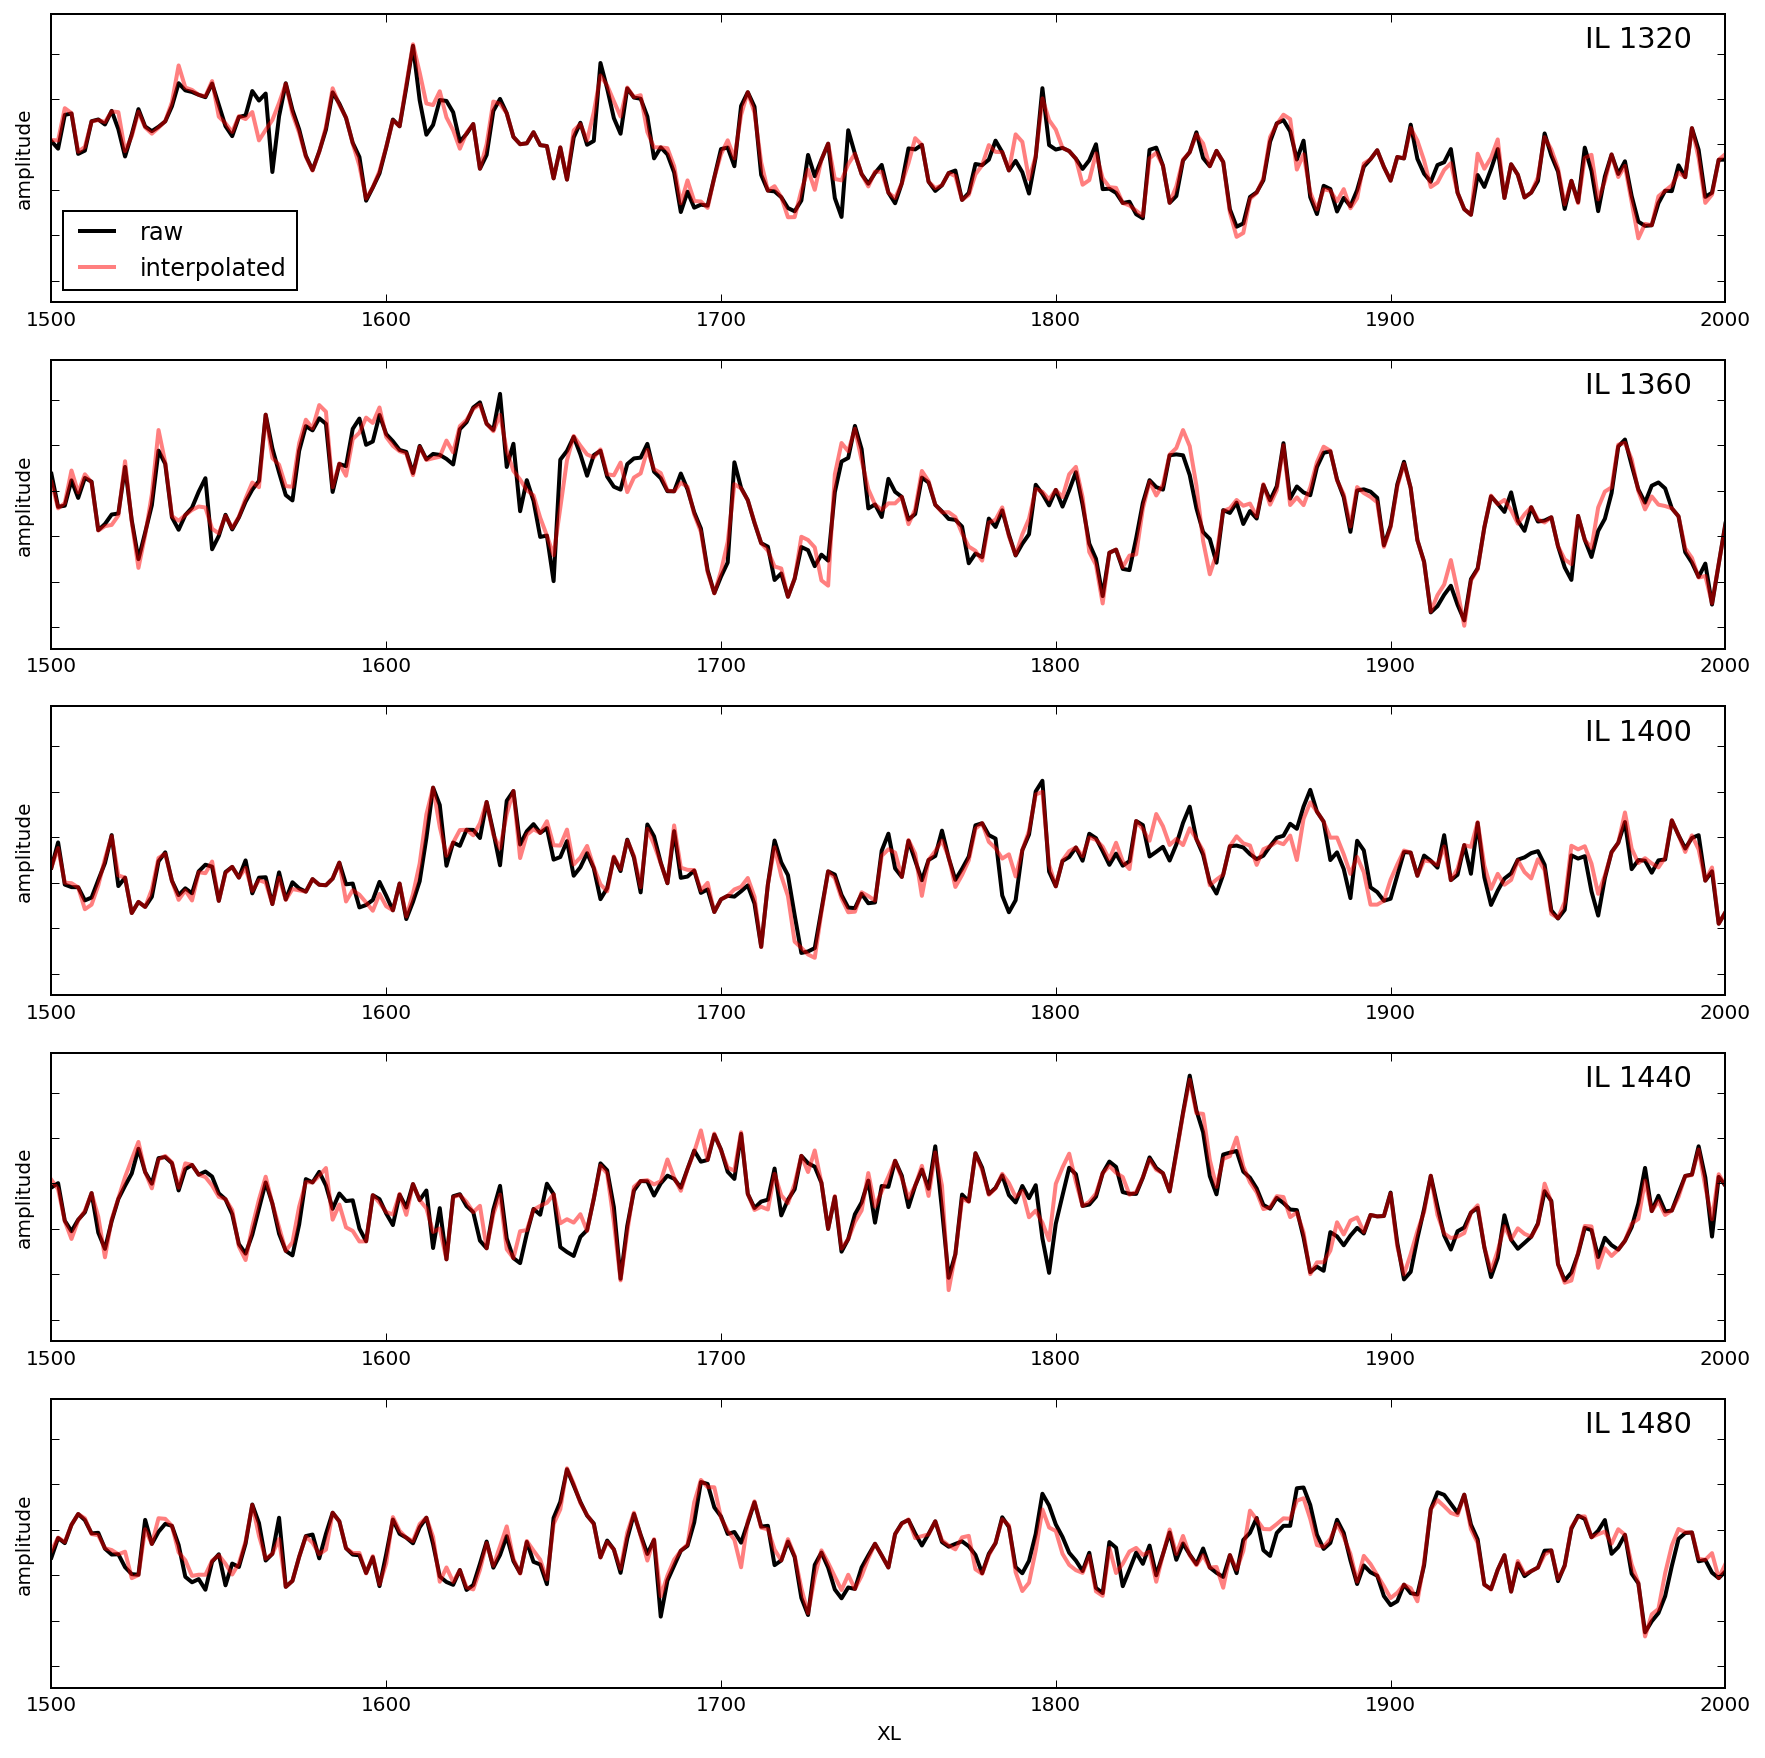

In [16]:
plt.figure()
plt.pcolormesh(X, Y, Araw, vmin=clip_min, vmax=clip_max, cmap='cubehelix', alpha=0.5)
for r,val in enumerate(inl[10::20]):
    plt.axvline(val, color='k', ls='--', lw=2)
plt.colorbar()
plt.axes().set_aspect(0.4)
plt.xlabel('IL'), plt.ylabel('XL')
plt.title('selected inlines')
    
f, ax = plt.subplots(inl[10::20].size,1,figsize=(15,15))
for r,val in enumerate(inl[10::20]):
    crosslines = hrz_extr[hrz_extr[:,0]==val][:,1]
    amp_raw    = hrz_extr[hrz_extr[:,0]==val][:,3]
    amp_splev  = hrz_extr[hrz_extr[:,0]==val][:,4]

    ax[r].plot(crosslines, amp_raw, '-k', lw=2, label='raw')
    ax[r].plot(crosslines, amp_splev, '-r', lw=2, alpha=0.5, label='interpolated')

    ax[r].set_ylim(clip_min,clip_max)
    ax[r].set_yticklabels([])
    ax[r].set_ylabel('amplitude')
    ax[r].text(0.98,0.96,'IL {0}'.format(val),size='x-large',
    ha='right',va='top',transform=ax[r].transAxes)
ax[0].legend(loc='lower left')
ax[r].set_xlabel('XL')

The conclusion (for me) is that the simplest approach is reasonably accurate, but since the time penalty of using interpolation (provided it is `splrep / splev` and not `interp1d`) is so small, then why not using it.

In this last plot I compare amplitudes extracted at the horizon with RMS values from a 32 ms window centered on the horizon; structure contours (in time) are superimposed on the maps.

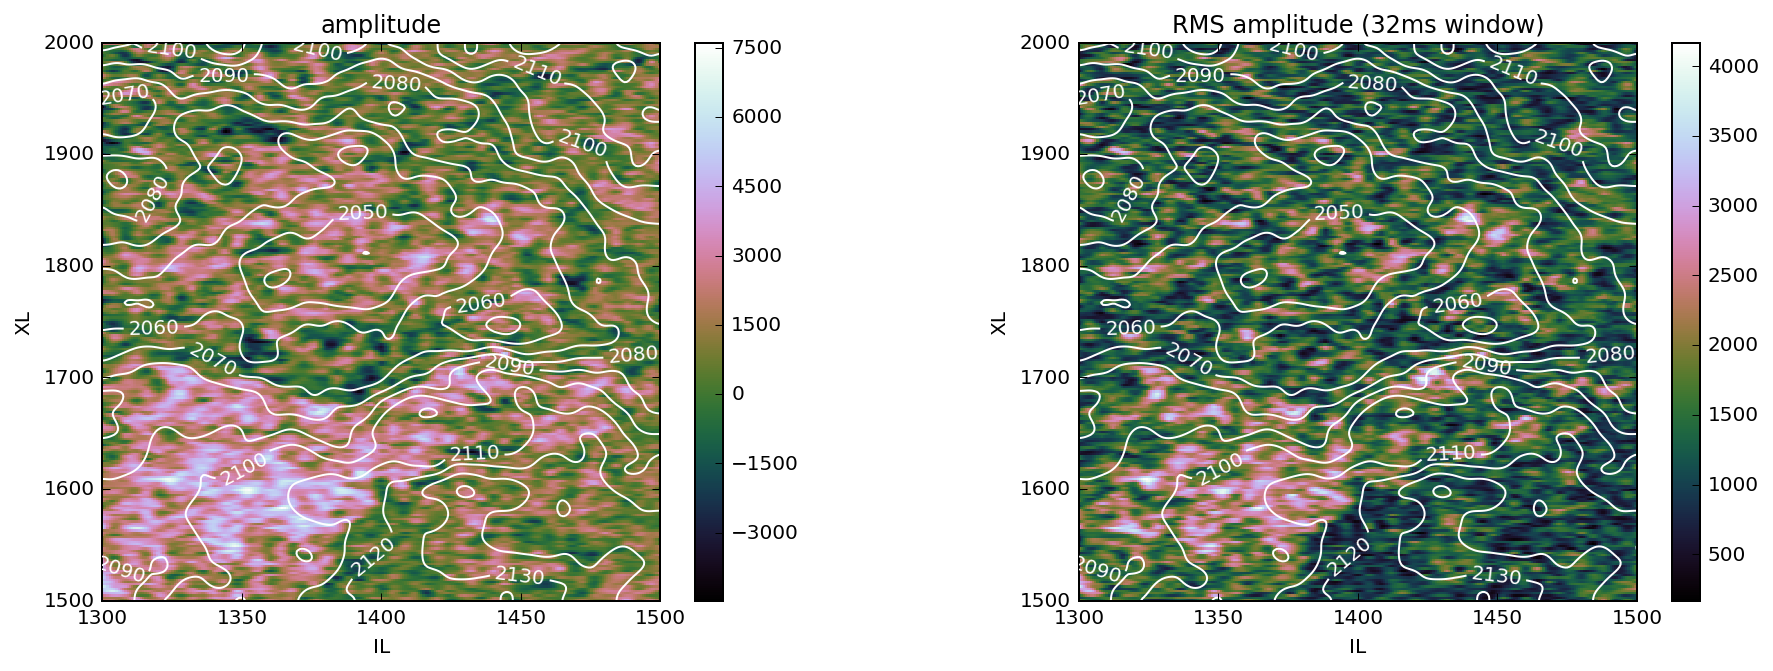

In [17]:
f, ax = plt.subplots(1,2,figsize=(15,5))
map0 = ax[0].pcolormesh(X, Y, Aspl, cmap='cubehelix')
map1 = ax[1].pcolormesh(X, Y, Arms, cmap='cubehelix')
plt.colorbar(map0, ax=ax[0])
plt.colorbar(map1, ax=ax[1])
ax[0].set_title('amplitude')
ax[1].set_title('RMS amplitude (32ms window)')
for aa in ax.flatten():
    aa.set_xlabel('IL'), aa.set_ylabel('XL')
    CS=aa.contour(X,Y,Zf,10,colors='w')
    plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
f.subplots_adjust(wspace=.4)

## a better/more complete function for amplitude extraction

Just building up on the previous code, here's a function to do amplitude extraction with options to extract instantaneous amplitude, interpolated, RMS, maximum/minimum value in a window etc. It's just a framework and many other attributes can be added like envelope, absolute maximum/minimum etc (just beware of the "redundant and useless" ones -- see Barnes, 2007).

Please note that the function below works in a inline=x and crossline=y reference; adjust accordingly (one day I will make something more general to deal with any kind of orientation).

In [90]:
def ampl_extract(hrz, seis, twt, sr, type='raw', window=8):
    # input horizon has to be a recarray with at least the following fields: il, xl, z
    # imported for example with hrz=np.recfromcsv('horizon.dat', names=['il','xl','z'])
    from scipy.interpolate import splev, splrep
    hrz_extr = np.zeros((hrz.size,4))
    for i in range(hrz.size):
        ii_idx=inl.tolist().index(hrz.il[i])
        cc_idx=crl.tolist().index(hrz.xl[i])
        zz_idx = np.abs(twt-hrz.z[i]).argmin()
        if type == 'raw':
            amp = seis[zz_idx, ii_idx, cc_idx].flatten()
        elif type == 'spl':
            trace = seis[:, ii_idx, cc_idx].flatten()
            ff = splrep(twt, trace)
            amp = splev(hrz.z[i], ff)
        elif type == 'rms':
            amp = np.sqrt(np.mean((np.square(seis[zz_idx-int(window/2):zz_idx+int(window/2), ii_idx, cc_idx]))))
        elif type == 'max':
            qq=seis[zz_idx-int(window/2):zz_idx+int(window/2), ii_idx, cc_idx]
            amp=np.max(qq)
        elif type == 'min':
            qq=seis[zz_idx-int(window/2):zz_idx+int(window/2), ii_idx, cc_idx]
            amp=np.min(qq)
        hrz_extr[i,0] = hrz.il[i]
        hrz_extr[i,1] = hrz.xl[i]
        hrz_extr[i,2] = hrz.z[i]
        hrz_extr[i,3] = amp
    return hrz_extr

In [91]:
amp_raw=ampl_extract(hrz, seis, twt, sr, type='raw')
amp_spl=ampl_extract(hrz, seis, twt, sr, type='spl')
amp_rms16=ampl_extract(hrz, seis, twt, sr, type='rms', window=16)
amp_rms48=ampl_extract(hrz, seis, twt, sr, type='rms', window=48)
amp_max=ampl_extract(hrz, seis, twt, sr, type='max')
amp_min=ampl_extract(hrz, seis, twt, sr, type='min')

In [92]:
Araw=griddata((amp_raw[:,0],amp_raw[:,1]),amp_raw[:,3],(X,Y),method='cubic')
Aspl=griddata((amp_spl[:,0],amp_spl[:,1]),amp_spl[:,3],(X,Y),method='cubic')
Arms16=griddata((amp_rms16[:,0],amp_rms16[:,1]),amp_rms16[:,3],(X,Y),method='cubic')
Arms48=griddata((amp_rms48[:,0],amp_rms48[:,1]),amp_rms48[:,3],(X,Y),method='cubic')
Amax=griddata((amp_max[:,0],amp_max[:,1]),amp_max[:,3],(X,Y),method='cubic')
Amin=griddata((amp_min[:,0],amp_min[:,1]),amp_min[:,3],(X,Y),method='cubic')

raw: max=7703.759264668469, min=-4624.013972349957
interpolated: max=7615.6990732254435, min=-4472.256869698136
rms 16ms: max=3878.3419307725676, min=289.29405124311126
rms 48ms: max=2941.84590090178, min=651.5121212716017
max: max=7673.043245714597, min=-226.49234350545026
min: max=1336.731817015901, min=-6791.825528985351


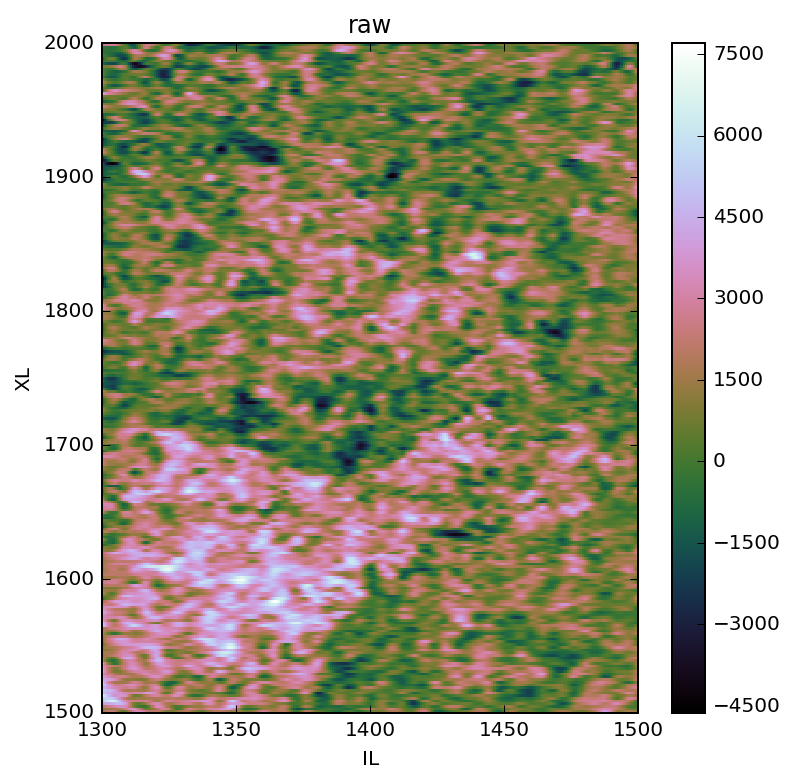

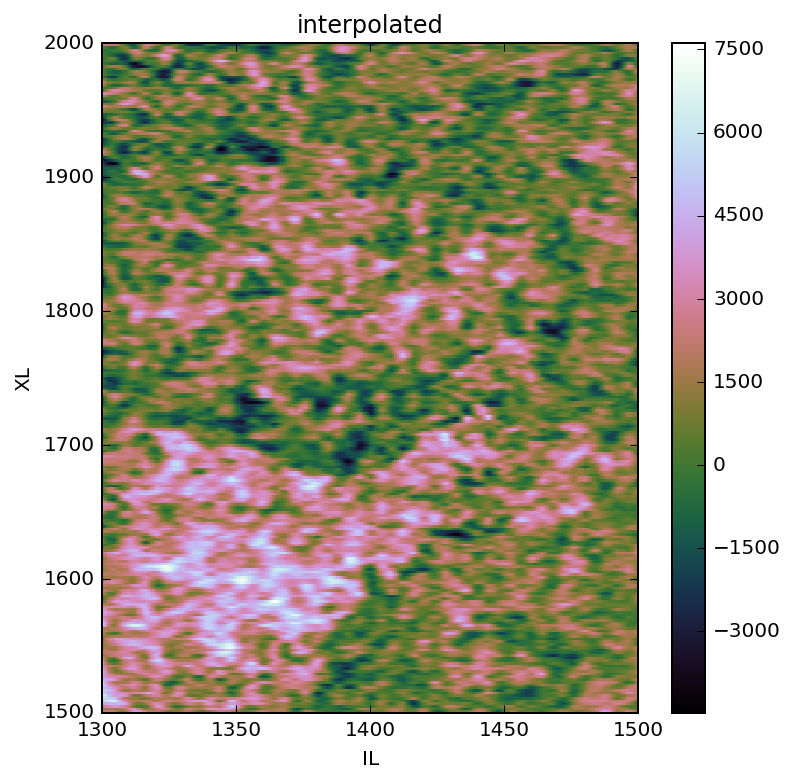

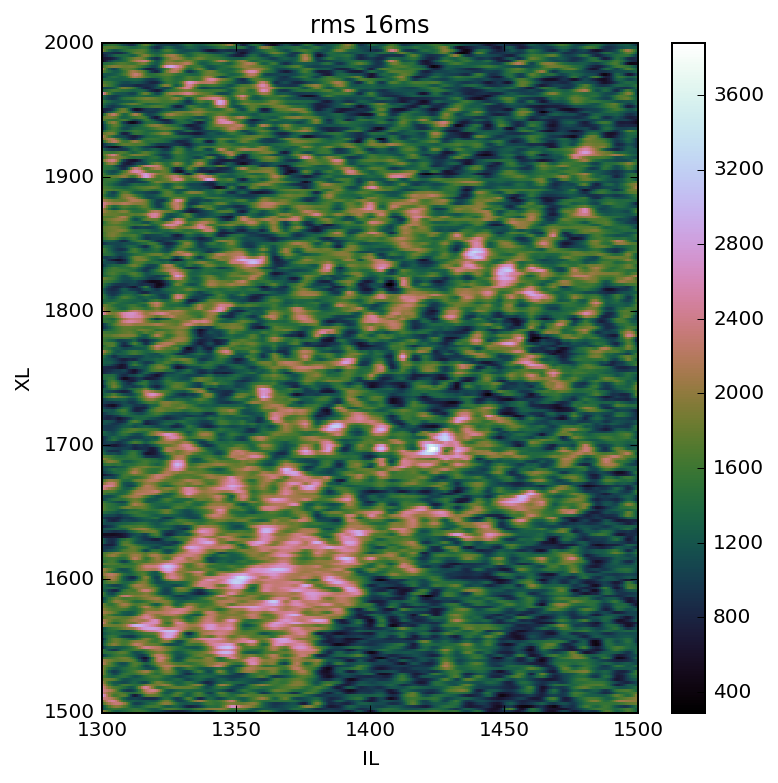

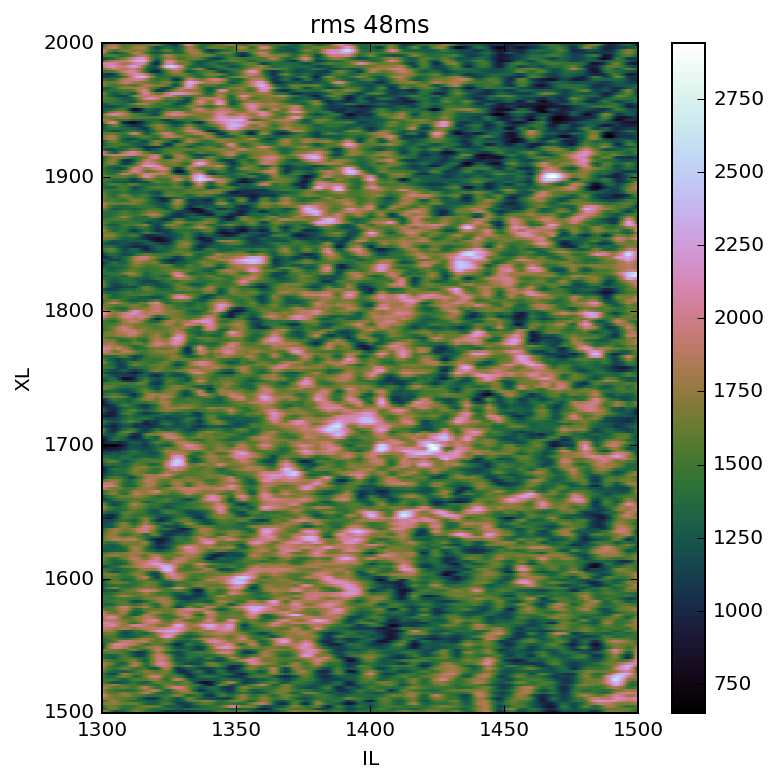

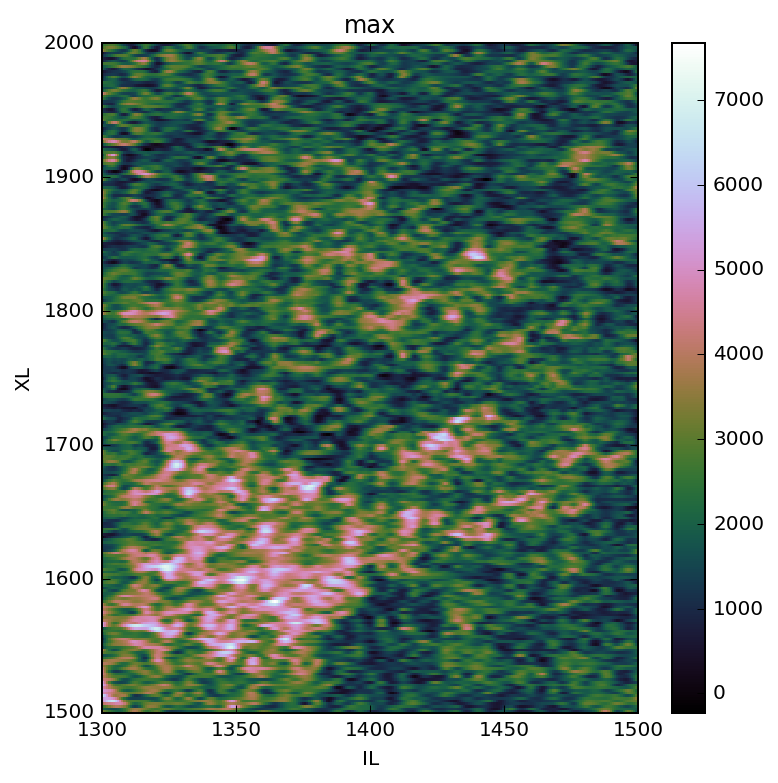

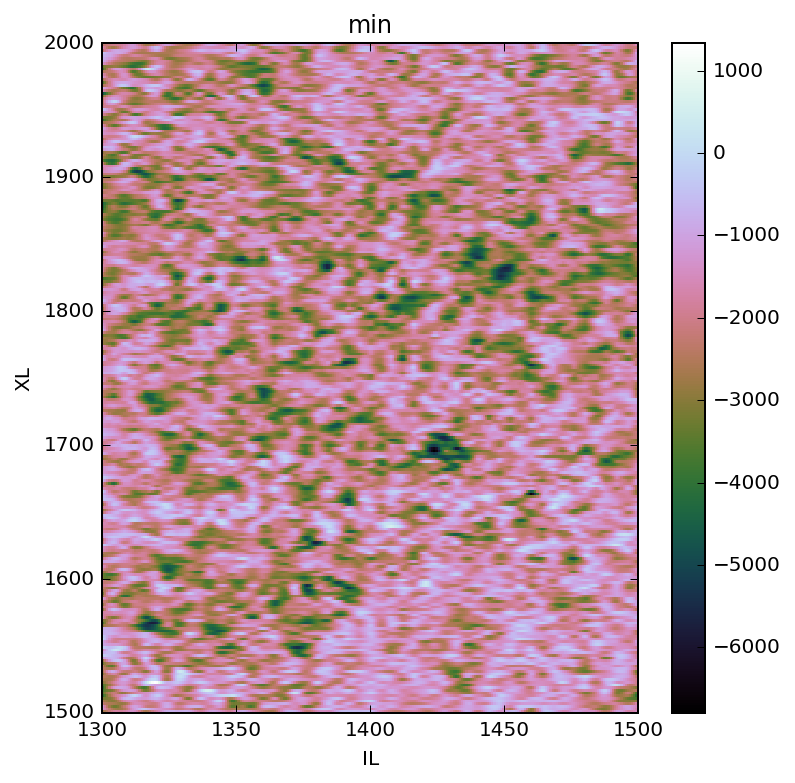

In [93]:
names=['raw','interpolated','rms 16ms', 'rms 48ms', 'max', 'min']
for i,aa in enumerate([Araw, Aspl, Arms16, Arms48, Amax, Amin]):
    clipmax=np.nanmax(aa)
    clipmin=np.nanmin(aa)
    print('{0}: max={1}, min={2}'.format(names[i], clipmax, clipmin))
    plt.figure(figsize=(6,6))
    plt.pcolormesh(X, Y, aa, cmap='cubehelix')
    plt.colorbar()
    plt.title(names[i])
    plt.xlabel('IL'), plt.ylabel('XL')

## further readings

* [Smoothing surfaces and attributes](http://library.seg.org/doi/abs/10.1190/tle33020128.1), by Matt Hall (article on The Leading Edge)
* [horizons and attributes](https://github.com/kwinkunks/notebooks/blob/master/Horizons_and_attributes.ipynb) by Matt Hall (the companion notebook to the above)
* [corendering attributes](https://github.com/agile-geoscience/notebooks/blob/master/Corendering_attributes.ipynb) and [corendering _more_ attributes](https://github.com/agile-geoscience/notebooks/blob/master/Corendering_more_attributes.ipynb) by Agile Geoscience (Jupyter notebooks)
* [Sobel filtering](https://github.com/kwinkunks/notebooks/blob/master/Sobel_filtering_horizons.ipynb) by Matt Hall (Jupyter notebook)
* Barnes, "Redundant and Useless Seismic Attributes." Geophysics, 2007.